## 7. Compute-EW-for-CIV.ipynb

This notebook computes the EW for the CIV doublet using
create_gaussian_fitter() and calculate_ew_from_gaussian() 
fitter is based on astropy models.Const1D() and models.Gaussian1D()
    
This code just loops through the pickle files for each sightline, observation, redshift


Flow
* select a single sightline with extraction box
* convert extraction box points to ra/dec corners
* load original data cube(s)
  * display whitelight image with extraction box
  * extract spectrum
  * display spectrum
* plot spectrum
* load 7 observations
  * display whitelight images for 7 observations with extraction box
  * for each extraction box
    * for each observation
      * extract spectra from observation
    * create combined spectra
* plot combined spectrum
* plot both with scaled point-wise delta

In [1]:
# import all the things

import sys
import numpy as np

from linetools.spectra.xspectrum1d import XSpectrum1D  
from linetools.utils import radec_to_coord

from kcwitools import image as im

from astropy.wcs import WCS, FITSFixedWarning
import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=FITSFixedWarning)

bu_path = '/Users/robertseaton/School/github_repos/CGM-learning/code'
if bu_path not in sys.path:
    sys.path.append(bu_path)
from bobutils import utils as bu, fileio as bio, layout_utils as bl, sightlines as bs, plotutils as bp, observations as bo

# globals
global_nb_min = 4676. 
global_nb_max = 4696. 
global_cmap = 'gnuplot'
global_lw = 0.5

In [2]:
# jupyterlab/mac/matplotlib inline craziness
# NOTE: You need the following lines for jupyter lab (commandline) to work on Mac !!!!
# NOTE: and you MUST run this cell twice (I don't know why) to get the image to appear inline
%matplotlib widget 
%matplotlib inline 
import matplotlib
import matplotlib.gridspec as gridspec

matplotlib.use('TkAgg') 

import matplotlib.pyplot as plt

In [3]:
def create_single_sightline():
    sightlines = []
    sightlines.append(bs.Sightline(x=36, y=38, w=3, h=3, label="A"))
    return sightlines

In [4]:
# load original (corrected) data cube(s) - flux and variance
# need to verify that this data is corrected consistent with the 7 observations data
# but also consistent with the way I was originally loading the data
# maybe try to use bobutils.extract_spectra(...) using only 1 flux & var file - 
#  This would ensure that both the original and 7obs data are processed identically. 
#  But it wouldn't give us a verification that our ivw adding matches the original data analysis.
# get_corrected_kcwi_data()
#  load_observations()
#    read_and_prep_flux_var_data()
#  build_whitelight()
def load_original_cubes_into_observation():
    base_path = "/Users/robertseaton/School/Physics-NCState/---Research/Analysis/J1429"
    # ~/School/Physics-NCState/---Research/Analysis/J1429/J1429+1202_KCWI_corrected_flux.fits
    flux_filename = base_path+"/J1429+1202_KCWI_corrected_flux.fits"
    var_filename = base_path+"/J1429+1202_KCWI_corrected_var.fits"

    minwave = 3500.
    maxwave = 5500.
    
    ob = bio.read_and_prep_flux_var_data(flux_filename, var_filename, minwave, maxwave, ybot=None, ytop=None)
    ob.wcs_flux = WCS(ob.hdr_f).celestial

    # Removing all the NaNs from the flux cube before making white-light or narrow-band image
    q_nan = np.isnan(ob.flux) 
    ob.flux[q_nan] = 0.0
    
    q_nan = np.isnan(ob.var) 
    ob.var[q_nan] = 9999

    ob.wl = im.build_whitelight(ob.hdr_f, ob.flux, minwave=global_nb_min, maxwave=global_nb_max)

    # Loading the variance cube from index 2 of the KCWI fits file
    ob.wcs_var = WCS(ob.hdr_v).celestial # The WCS of the variance cube
    
    return ob

In [14]:
def display_spec(ax_spec, xspec, label=f"Spectra", figsize=(5,1), dpi=200, fontsize=12, showErr=True):
    lw = 0.5

    rows = 4
    cols = 3
    
    wave = xspec.wavelength.value
    spec = xspec.flux.value
    err = xspec.sig.value
    if showErr: ax_spec.plot(wave, err, 'r-', lw=lw, label="Error")
    ax_spec.plot(wave, spec, 'b-', lw=lw, label="Flux")

    ax_spec.set_xlabel("Wavelength")
    ax_spec.set_ylabel("Flux & Error")
    # ax_err.set_ylabel("Error")
    ax_spec.legend()
    ax_spec.text(0.05, 0.9, 
            f"{label}",
            color="b", 
            fontsize = fontsize, 
            ha='left', va='top',
            transform=ax_spec.transAxes)
    

    # display the spectrum and variance
    plt.subplots_adjust(left=0.079, bottom=0.043, right=0.967, top=0.952, wspace=0.638, hspace=0.35)
    

sl=Sightline A: x=36, y=38, w=3, h=3, radecs=(array([217.47848142, 217.47823308]), array([12.04394905, 12.04419193])) 
=============== BEGINNING EXTRACTION FOR RA:217.47848142381017 DEC:12.04394905028928 ==================


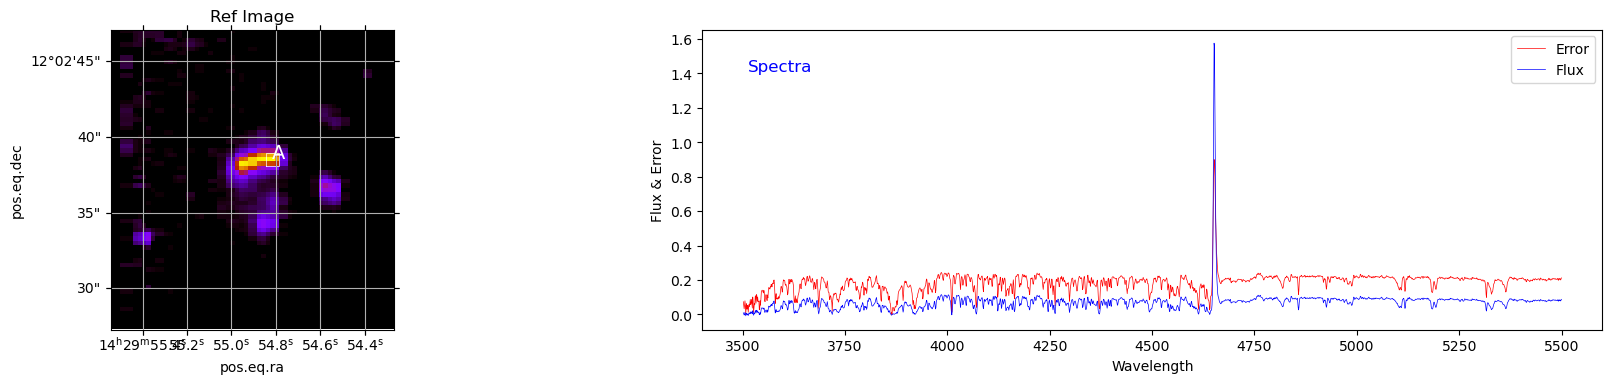

In [15]:
# * select a single sightline with extraction box
slines = create_single_sightline()

# * load original data cube(s)
obs_orig = load_original_cubes_into_observation()

# * convert extraction box points to ra/dec corners in world coordinates
slines = bs.add_radec_to_sightlines(obs_orig.wcs_flux, slines)
for sl in slines: print(f"{sl=}")

#   * display whitelight image with extraction box
plt.close()
fig = plt.figure(figsize=(3,3), dpi=100)
ax_image = fig.add_axes((0,0,1,1), projection=obs_orig.wcs_flux, polar=False)
ax_spec = fig.add_axes((2,0,3,1))

# show the image + sightlines
bp.show_wl_image(ax_image, obs_orig.wl, title="Ref Image")
bp.plot_sightlines_wcs(ax_image, obs_orig.wcs_flux, slines, label=slines[0].label, lw=0.5, show_label=True)

# show the spectrum
xpec1d_orig = bo.extract_spectra_from_obs(slines[0].radecs, [obs_orig])
display_spec(ax_spec, xpec1d_orig[0])

display(fig) # plots the figure as a static png


In [16]:
def plot_observation(obs, ax_image, wcs, sightlines, index, xh_lim=None, yh_lim=None):
    ax_image.margins(-0.15) # zoom a little
    
    bp.show_wl_image(ax_image, obs.wl, xh_lim, yh_lim)
    
    ax_image.set_title(label=f"Observation {index}", fontsize=14, ha='center', va='bottom')
    bp.plot_sightlines_wcs(ax_image, wcs, slines, label=slines[0].label, lw=0.5, show_label=True)
    

In [17]:
def transform_pixels(x1, y1, wcs1, wcs2):
    ra, dec = wcs1.pixel_to_world_values(x1, y1) # from this
    x2, y2 = wcs2.world_to_pixel_values(ra, dec) # to this
    return x2, y2


sl=Sightline A: x=36, y=38, w=3, h=3, radecs=(array([217.47848142, 217.47823308]), array([12.04394905, 12.04419193])) 


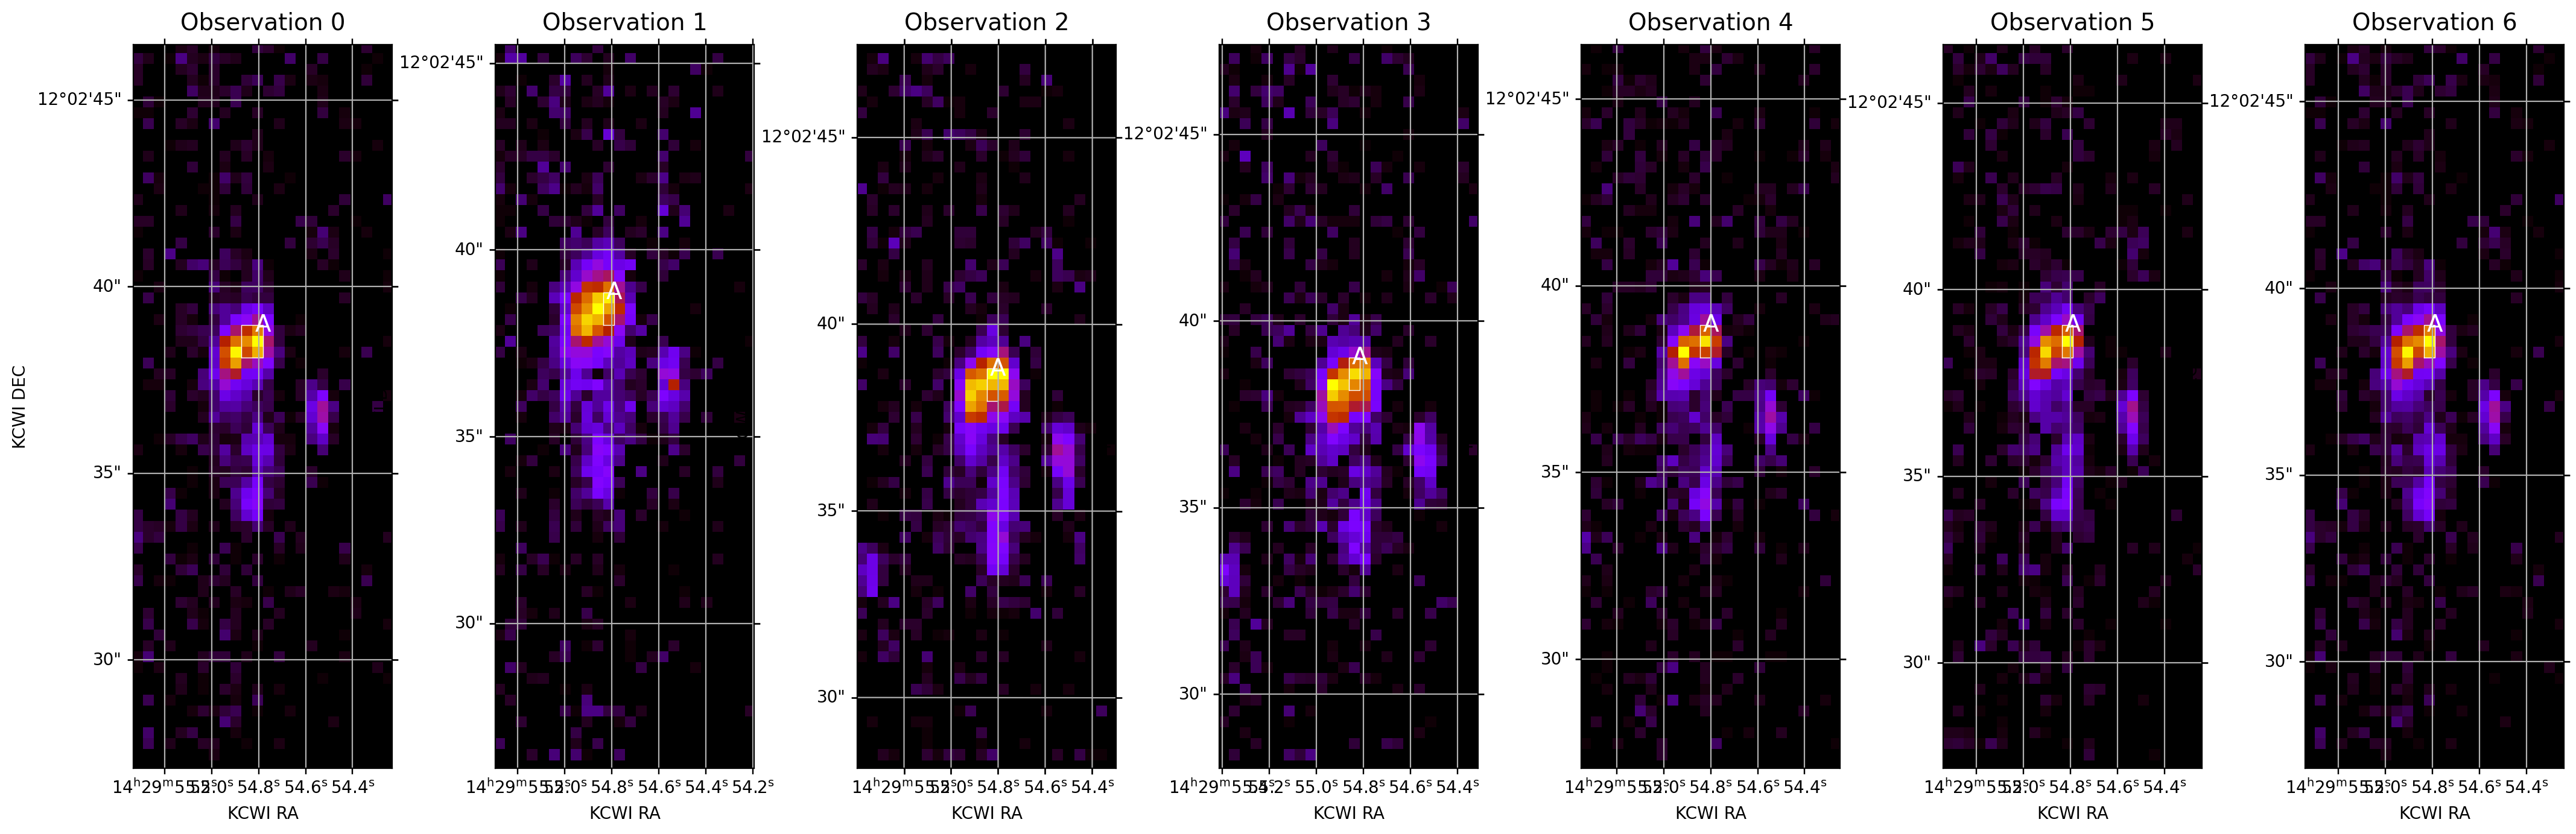

In [18]:
#-------------------------------------------------------------------------------------------
# * load 7 observations
obs = bio.get_corrected_kcwi_data(global_nb_min, global_nb_max)

#   * display whitelight images for 7 observations with sightline/extraction box
plt.close()
fig = plt.figure(figsize=(3,3), dpi=200)
rows = 1
cols = 7

for sl in slines: print(f"{sl=}")

for ndx in range(len(obs)): 
    wcs_cur = obs[ndx].wcs_flux
    
    ax_image = fig.add_axes((ndx,0,1,2), projection=wcs_cur, polar=False)
    plot_observation(obs[ndx], ax_image, wcs_cur, slines, ndx)
    
display(fig) # plots the figure as a static png

In [19]:
def plot_spectra(sl, xspec, label=f"Sightline: {sl.label}", figsize=(5,1), dpi=200, fontsize=12):
    """plot_spectra plots the associated XSpectrum1D with a single sightline. 
    Args:   sl (Sightline): _description_
            spec_block (spec,var,wave): _description_
    """
    wave = xspec.wavelength.value
    spec = xspec.flux.value
    err = xspec.sig.value
        
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax_spec = fig.add_axes((0,0,1,1))

    ax_spec.plot(wave, spec, '-', color="k", linewidth=0.5, label="flux")
    ax_spec.set_xlabel('wavelength (Angstroms)')
    ax_spec.set_ylabel('Flux', color='k', rotation=90)  # Primary y-axis label, rotated
    ax_spec.tick_params(axis='y', labelcolor='k')
    # ax_spec.plot(wave, err, '-', color="r", linewidth=0.5, label="error")
    ax_spec.legend(loc='upper right', fontsize=fontsize-2)

    ax_spec.text(0.05, 0.9, 
            f"{label}",
            color="w", 
            fontsize = fontsize, 
            ha='left', va='top',
            transform=ax_spec.transAxes)
 
    ax_spec.set_facecolor('darkgrey')
    
    display(fig) # plots the figure as a static png

=============== BEGINNING EXTRACTION FOR RA:217.47848142381017 DEC:12.04394905028928 ==================
SQRT the variance for observation 6


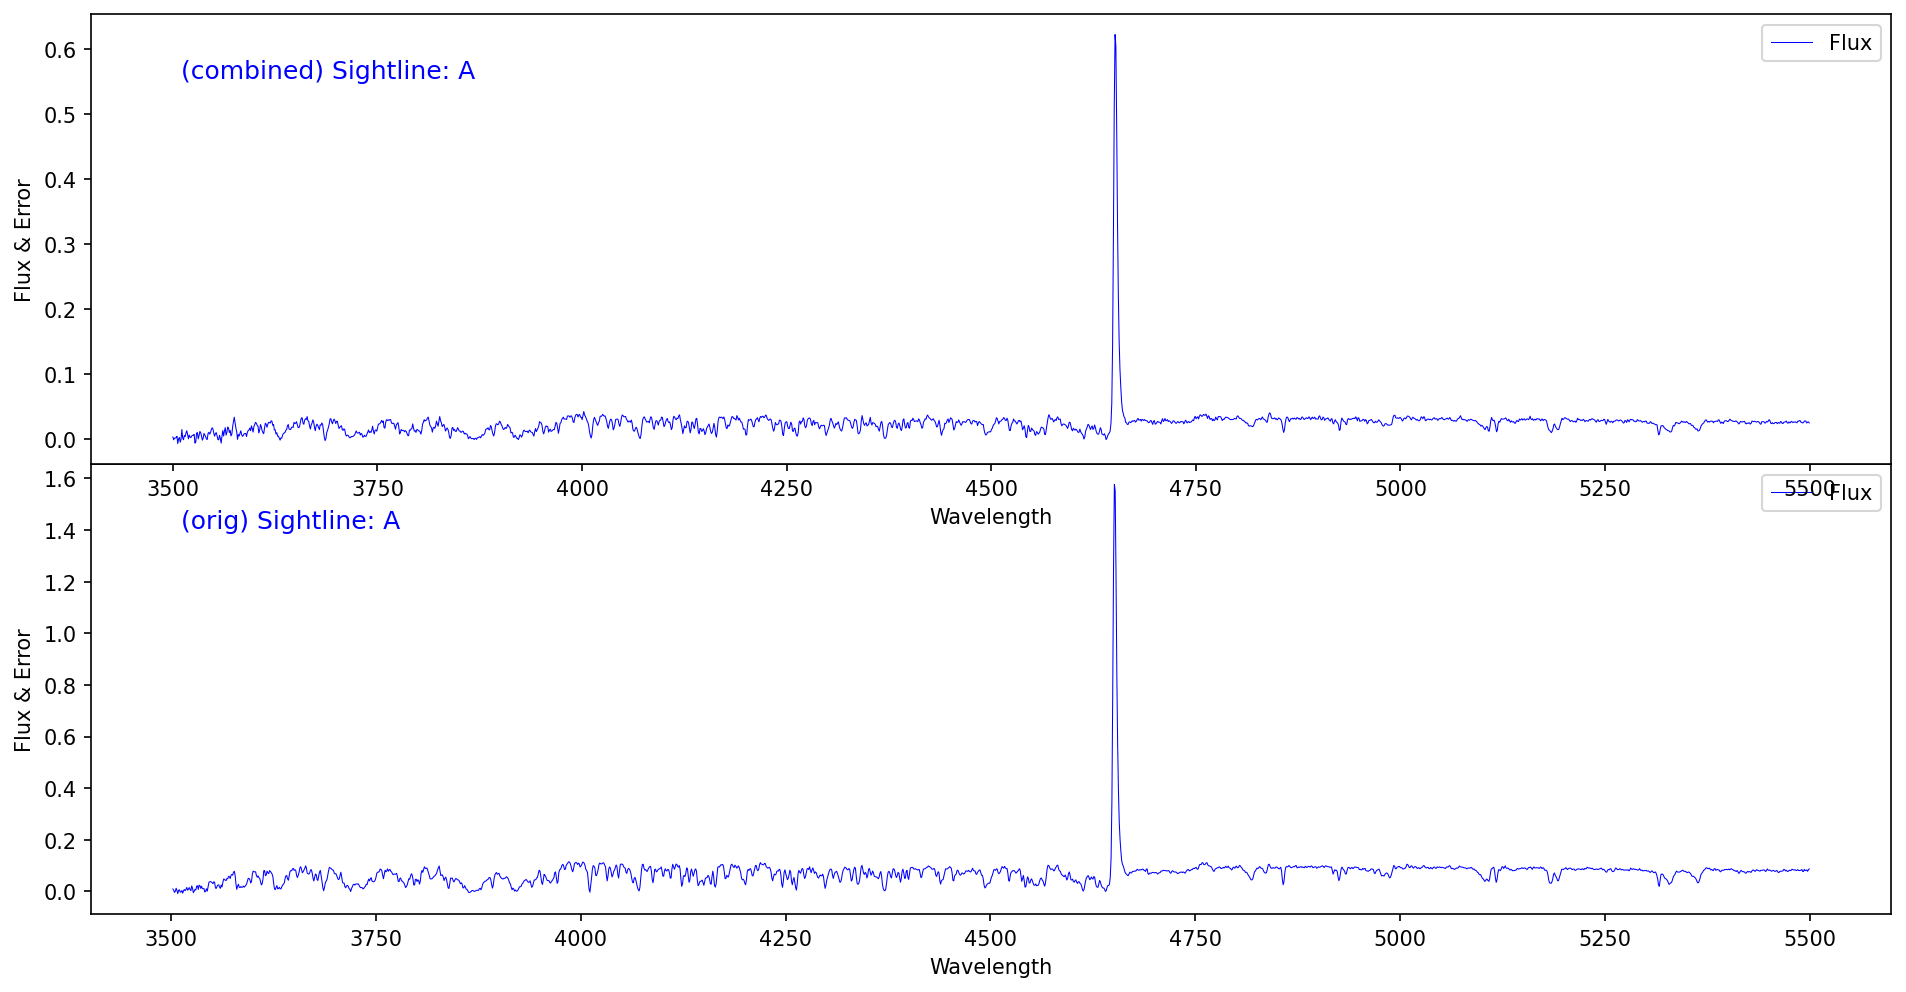

In [28]:
#   * for each extraction box
#     * for each observation
#       * extract spectra from observation
#     * create combined spectra
# * plot combined spectrum
sl_radec = slines[0].radecs
specs = bo.extract_spectra_from_obs(sl_radec, obs)    
xpec1d_combined = bu.combine_spectra_ivw2(specs)            
# plot_spectra(sl, xpec1d_combined, label=f"(combined) Sightline: {sl.label}")
# plot_spectra(sl, xpec1d_orig[0], label=f"(orig) Sightline: {sl.label}")

fig = plt.figure(figsize=(4,3), dpi=150)
ax_spec_orig = fig.add_axes((0,0,3,1))
ax_spec_comb = fig.add_axes((0,1,3,1))

display_spec(ax_spec_orig, xpec1d_orig[0], label=f"(orig) Sightline: {sl.label}", showErr=False )
display_spec(ax_spec_comb, xpec1d_combined, label=f"(combined) Sightline: {sl.label}", showErr=False)
display(fig) # plots the figure as a static png

# * plot both with scaled point-wise delta